In [1]:
import os

from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.model_selection import *
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.ensemble import *
from sklearn.metrics import *
from tabulate import tabulate
from sklearn.svm import SVC
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
SEP       = os.path.sep
ROOT_PATH = SEP.join(os.getcwd().split(SEP)[:-3])
DATA_PATH = f'{ROOT_PATH}/Dataset/breast cancer/Breast_Cancer.csv'

In [3]:
def set_style(ax, left = True, bottom = False, axis_grid = 'y'):
    
    sns.despine(ax = ax, left = left, bottom = bottom)
    ax.grid(axis = axis_grid, linewidth = 0.2, color = 'black')
    
    
def plot_scatter(data, feat_x, feat_y, ax, 
                 hue_column = None, colors = ['orange', 'blue'],
                 xlabel = None, ylabel = None, title = None):
    
    if hue_column:
        
        for idx, value in enumerate(data[hue_column].unique()):
            
            sub_data = data[data[hue_column] == value]
            ax.scatter(x = sub_data[feat_x] + np.random.normal(0, 1, sub_data.shape[0]),
                       y = sub_data[feat_y] + np.random.normal(0, 1, sub_data.shape[0]),
                       c = colors[idx], s = 4, alpha = 0.6, label = value)
        
        ax.legend()
    
    else:
        ax.scatter(x = data[feat_x] + np.random.normal(0, 1, data.shape[0]),
                   y = data[feat_y] + np.random.normal(0, 1, data.shape[0]),
                   c = colors[0], s = 2, alpha = 0.6)
        
    sns.despine(ax = ax, left = True)
    ax.set(xlabel = xlabel, ylabel = ylabel, title = title)
    
    
def plot_roc(fpr, tpr, ax, label = None, color = "#15616D"):
    
    ax.plot(fpr, tpr, label = label, color = color, linewidth = 3)
    ax.plot([0, 1], [0, 1], linewidth = 2,  color = 'gray', linestyle = '--')
    
    ax.set_xlim(left   = 0, right = 1)
    ax.set_ylim(bottom = 0,   top = 1)
    
    ax.set(xlim = [0, 1], ylim = [0, 1],
           xlabel = 'FPR', ylabel = 'TPR', title = 'ROC Curve')
    
    set_style(ax = ax, left = True)
    if label: ax.legend()


def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, ax):
    
    ax.plot(thresholds, precisions[ :-1], color = '#8377D1', 
            label = 'Precision', linewidth = 3)
    ax.plot(thresholds, recalls[ :-1]   , color = '#E69597',
            label = 'Reall', linewidth = 3)
    
    
    if np.amax(thresholds) <= 1:
        
        ax.axvline(x = 0.5, linewidth = 1, linestyle = '--', color = 'gray')
        
    set_style(ax, left = False)
    
    ax.set_xlabel('Threshold')
    ax.set_title('Precision-Recall Tradeoff', pad = 0)
    
    ax.set_xlim(left = np.amin(thresholds), right = np.amax(thresholds))
    ax.set_ylim(bottom = 0)
    
    ax.legend()
    
    
def plot_confusion_matrix(conf_mat, ax, 
                          palette = sns.color_palette('light:#AFA7E1', as_cmap = True)):
    
    sns.heatmap(conf_mat, ax = ax, vmin = 0, annot = True, fmt = 'd', linewidth = 1, linecolor = 'black', cmap = palette)
    ax.set_title('confusion matrix')
    sns.despine(ax = ax, right = False, top = False)
    
    
def plot_count(column, ax):
    
    data       = column.value_counts()
    data.index = data.index.map(str)
    
    ax.bar(x = data.index, height    = data.values,
           linewidth =  2, edgecolor = 'black', color = ['orange', 'blue'], alpha = 1)
    
    labels = [f'{round(value / sum(data.values) * 100, 1)}%'
              for value in data.values]
    
    for container in ax.containers:
        ax.bar_label(container, labels = labels, padding = 3, fontsize = 15)
        
    set_style(ax)
    

def classifier_evaluation(y_true, y_predict, y_scores, label="Test"):

    accuracy  = accuracy_score(y_true, y_predict)
    precision = precision_score(y_true, y_predict)
    recall    = recall_score(y_true, y_predict)
    f1        = f1_score(y_true, y_predict)
    auc       = roc_auc_score(y_true, y_scores)

    header    = ["Accuracy", "Precision", "Recall", "F1 Score", "Auc Score"]
    
    data      = [accuracy, precision, recall, f1, auc]
    data      = [round(el, 2) for el in data]

    table     = [header, data]

    if label:
        print(f"{label} scores")

    print(tabulate(table, headers="firstrow", tablefmt="rst"))


def roc_curve_evaluation(y_true, y_scores, ax, model_name=None, color=None):

    fpr, tpr, ths = roc_curve(y_true, y_scores)

    if color:
        plot_roc(fpr, tpr, ax, label=model_name, color=color)
    else: 
        plot_roc(fpr, tpr, ax, label=model_name)


def precision_recall_tradeoff(y_true, y_scores, ax):

    precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)

    plot_precision_recall_vs_threshold(precisions, recalls, thresholds, ax)


def show_confusion_matrix(y_true, y_pred, ax):

    conf_matrix = confusion_matrix(y_true, y_pred)

    plot_confusion_matrix(conf_matrix, ax)
    
    
def fit_pred_evaluate(model, X_train, y_train, X_test, y_test, train_label="Train", test_label="Validation", graph_valutation_train=False, graph_valutation_test=False):
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_score_train = model.predict_proba(X_train)[:, 1]

    y_pred_test = model.predict(X_test)
    y_score_test = model.predict_proba(X_test)[:, 1]

    classifier_evaluation(y_train, y_pred_train, y_score_train, label=train_label) 
    classifier_evaluation(y_test, y_pred_test, y_score_test, label=test_label)

    if graph_valutation_train:
        fig, axs = plt.subplots(1, 3, figsize=(20, 5))

        show_confusion_matrix(y_train, y_pred_train, axs[0])
        roc_curve_evaluation(y_train, y_score_train, axs[1])
        precision_recall_tradeoff(y_train, y_score_train, axs[2])

        fig.suptitle(train_label)

        plt.show()

    if graph_valutation_test:
        fig, axs = plt.subplots(1, 3, figsize=(20, 5))

        show_confusion_matrix(y_test, y_pred_test, axs[0])
        roc_curve_evaluation(y_test, y_score_test, axs[1])
        precision_recall_tradeoff(y_test, y_score_test, axs[2])

        fig.suptitle(test_label)

        plt.show()

In [4]:
df = pd.read_csv(DATA_PATH)
df.head(3)

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,68,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,4,Positive,Positive,24,1,60,Alive
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,2,Regional,35,Positive,Positive,14,5,62,Alive
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,2,Regional,63,Positive,Positive,14,7,75,Alive


In [5]:
df.rename(columns = {
            'Reginol Node Positive' : 'Regional Node Positive'
        }, inplace = True)

status_dict  = {'Dead' : 1, 'Alive' : 0}
df['Status'] = pd.to_numeric(df['Status'].replace(status_dict))
print(f'new status values : {df["Status"].value_counts()}')

df['Regional Node Positive %'] = (df['Regional Node Positive'] / df['Regional Node Examined'] * 100).round(2)
df.drop(['Race'], axis = 1, inplace = True)

df_dummies = pd.get_dummies(df)
df_dummies.head()

new status values : 0    3408
1     616
Name: Status, dtype: int64


,Age,Tumor Size,Regional Node Examined,Regional Node Positive,Survival Months,Status,Regional Node Positive %,Marital Status_Divorced,Marital Status_Married,Marital Status_Separated,...,Grade_ anaplastic; Grade IV,Grade_1,Grade_2,Grade_3,A Stage_Distant,A Stage_Regional,Estrogen Status_Negative,Estrogen Status_Positive,Progesterone Status_Negative,Progesterone Status_Positive
0,68,4,24,1,60,0,4.17,0,1,0,...,0,0,0,1,0,1,0,1,0,1
1,50,35,14,5,62,0,35.71,0,1,0,...,0,0,1,0,0,1,0,1,0,1
2,58,63,14,7,75,0,50.00,1,0,0,...,0,0,1,0,0,1,0,1,0,1
3,58,18,2,1,84,0,50.00,0,1,0,...,0,0,0,1,0,1,0,1,0,1
4,47,41,3,1,50,0,33.33,0,1,0,...,0,0,0,1,0,1,0,1,0,1


In [6]:
seed = 99
X    = df_dummies.drop('Status', axis = 1)
y    = df_dummies['Status']

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.25, shuffle = True,
                                                    stratify = y, random_state = seed)

ss             = StandardScaler()
scaled_train_x = ss.fit_transform(train_x)
scaled_test_x  = ss.fit_transform(test_x)

In [7]:
not_linear_models = {
                         'Random Forest'      :     RandomForestClassifier,
                         'AdaBoost'           :         AdaBoostClassifier,
                         'Gradient Boosting'  : GradientBoostingClassifier,
                         'K Neighbors'        :       KNeighborsClassifier,
                         'Decision Tree'      :     DecisionTreeClassifier
                     }

linear_models     = {
                        'Logistic Regression' : LogisticRegression,
                        'SVC'                 : SVC
                    }


for key in not_linear_models.keys():
    
    model = not_linear_models[key]()
    model.fit(train_x, train_y)
    
    pred_train_y      = model.predict(train_x)
    pred_test_y       = model.predict(test_x)
    
    try:
        y_score_train = model.predict_proba(train_x)[:, 1]
        y_score_test  = model.predict_proba(test_x)[:, 1]
        
    except:
        y_score_train = model.decision_function(train_x)[:, 1]
        y_score_test  = model.decision_function(test_x)[:, 1]
        
    
    print('\n\n')
    print(f'Model : {key}')
    classifier_evaluation(train_y, pred_train_y, y_score_train, label = 'Train')
    
    print('\n')
    classifier_evaluation( test_y,  pred_test_y,  y_score_test, label = 'Test')




Model : Random Forest
Train scores
==========  ===========  ========  ==========  ===========
  Accuracy    Precision    Recall    F1 Score    Auc Score
==========  ===========  ========  ==========  ===========
         1            1         1           1            1
==========  ===========  ========  ==========  ===========


Test scores
==========  ===========  ========  ==========  ===========
  Accuracy    Precision    Recall    F1 Score    Auc Score
==========  ===========  ========  ==========  ===========
       0.9         0.79      0.44        0.57         0.83
==========  ===========  ========  ==========  ===========



Model : AdaBoost
Train scores
==========  ===========  ========  ==========  ===========
  Accuracy    Precision    Recall    F1 Score    Auc Score
==========  ===========  ========  ==========  ===========
      0.91         0.78      0.55        0.65         0.91
==========  ===========  ========  ==========  ===========


Test scores
==========  ====

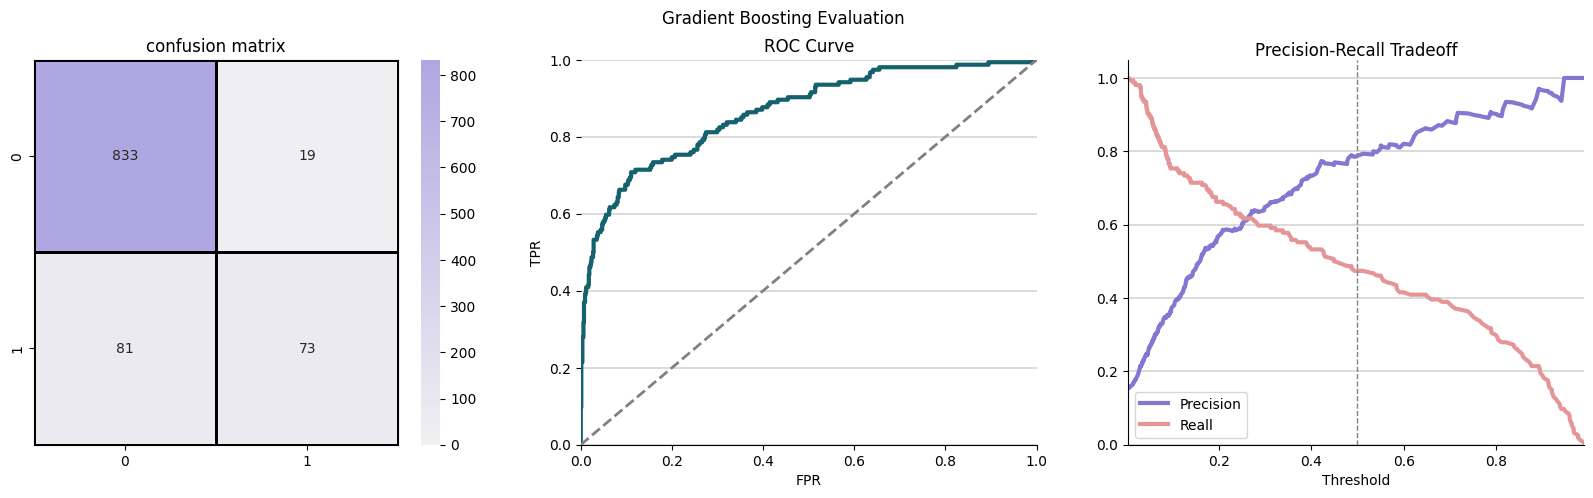

In [8]:
model = GradientBoostingClassifier(random_state = seed)
model.fit(train_x, train_y)

y_pred_test  = model.predict(test_x)
y_score_test = model.predict_proba(test_x)[:, 1]

fig, ax = plt.subplots(1, 3, figsize = (20, 5))

show_confusion_matrix(test_y, y_pred_test, ax[0])
roc_curve_evaluation( test_y, y_score_test, ax[1])
precision_recall_tradeoff(test_y, y_score_test, ax[2])

fig.suptitle('Gradient Boosting Evaluation')
plt.show()

Test - Threshold : 0.5 | scores
==========  ===========  ========  ==========  ===========
  Accuracy    Precision    Recall    F1 Score    Auc Score
==========  ===========  ========  ==========  ===========
       0.9         0.79      0.47        0.59         0.86
==========  ===========  ========  ==========  ===========


Test - Threshold : 0.2 | scores
==========  ===========  ========  ==========  ===========
  Accuracy    Precision    Recall    F1 Score    Auc Score
==========  ===========  ========  ==========  ===========
      0.87         0.57      0.66        0.61         0.86
==========  ===========  ========  ==========  ===========




Text(0.5, 1.0, 'Confusion matrix - Threshold : 0.2')

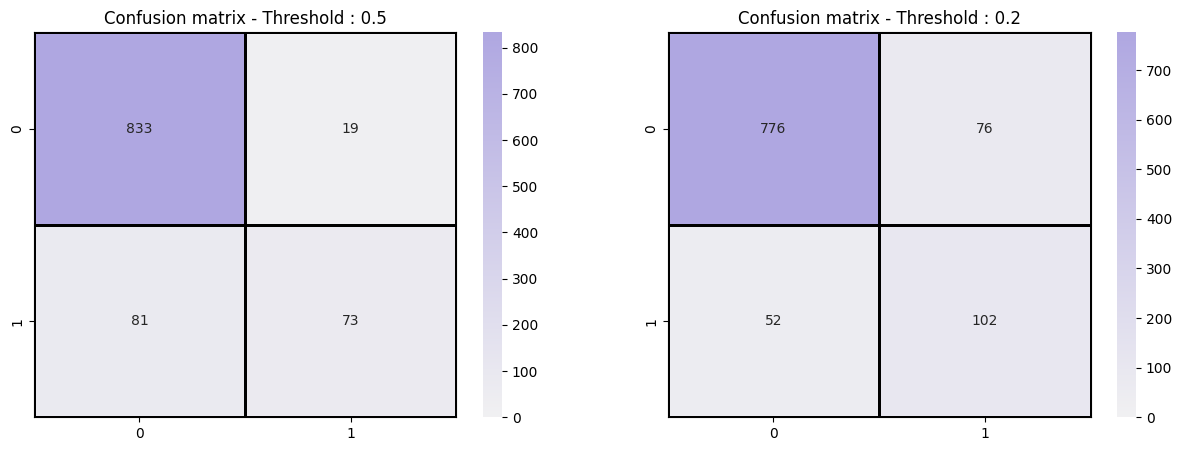

In [9]:
def predict_by_threshold(y_scores, threshold):
    
    y_predict = []
    for y_value in y_scores:
        
        if y_value > threshold: y_predict.append(1)
        else: y_predict.append(0)
        
    return np.array(y_predict)


y_pred_test_ = predict_by_threshold(y_score_test, 0.2)
classifier_evaluation(test_y, y_pred_test, y_score_test,
                      label = 'Test - Threshold : 0.5 |')
print('\n')
classifier_evaluation(test_y, y_pred_test_, y_score_test,
                      label = 'Test - Threshold : 0.2 |')
print('\n')

fig, ax = plt.subplots(1, 2, figsize = (15, 5))

show_confusion_matrix(test_y,  y_pred_test, ax[0])
ax[0].set_title('Confusion matrix - Threshold : 0.5')

show_confusion_matrix(test_y, y_pred_test_, ax[1])
ax[1].set_title('Confusion matrix - Threshold : 0.2')

In [10]:
pca = PCA(random_state = seed)
pca.fit(scaled_train_x)

x_train_red = pca.transform(scaled_train_x)
x_test_red  = pca.transform(scaled_test_x)

Training Data - PCA scores
==========  ===========  ========  ==========  ===========
  Accuracy    Precision    Recall    F1 Score    Auc Score
==========  ===========  ========  ==========  ===========
      0.93         0.92      0.61        0.73         0.95
==========  ===========  ========  ==========  ===========
Test Data - PCA scores
==========  ===========  ========  ==========  ===========
  Accuracy    Precision    Recall    F1 Score    Auc Score
==========  ===========  ========  ==========  ===========
      0.89         0.72      0.42        0.53         0.84
==========  ===========  ========  ==========  ===========


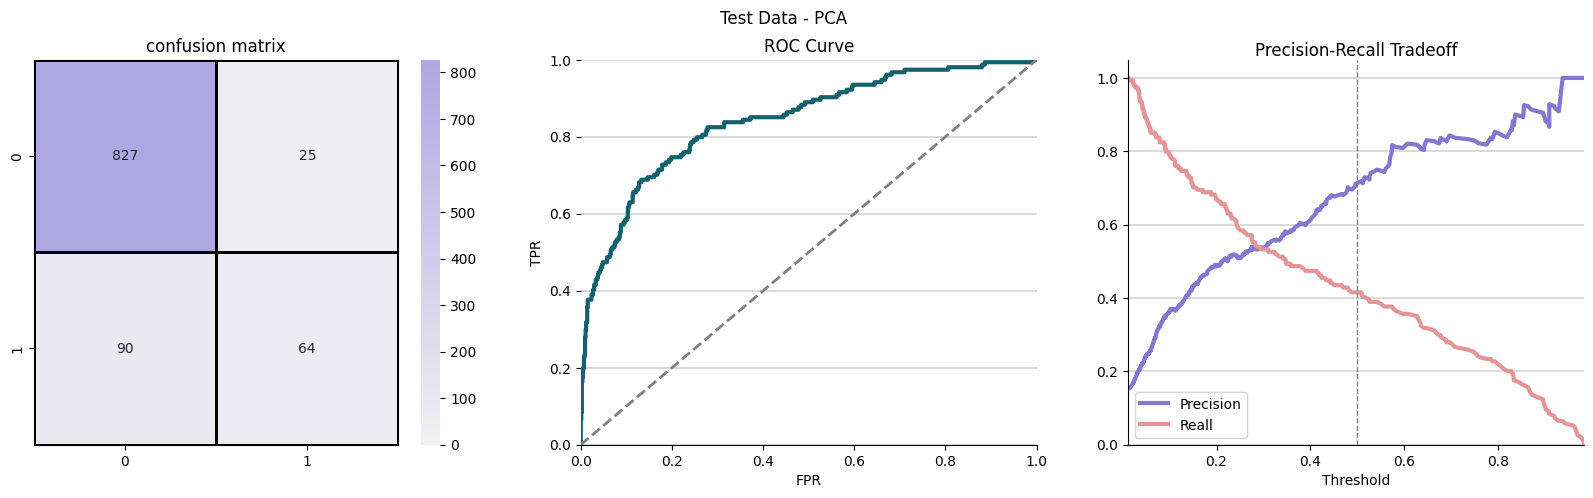

In [11]:
fit_pred_evaluate(model, x_train_red, train_y, x_test_red, test_y,
                  train_label = 'Training Data - PCA',
                  test_label  = 'Test Data - PCA', graph_valutation_test = True)

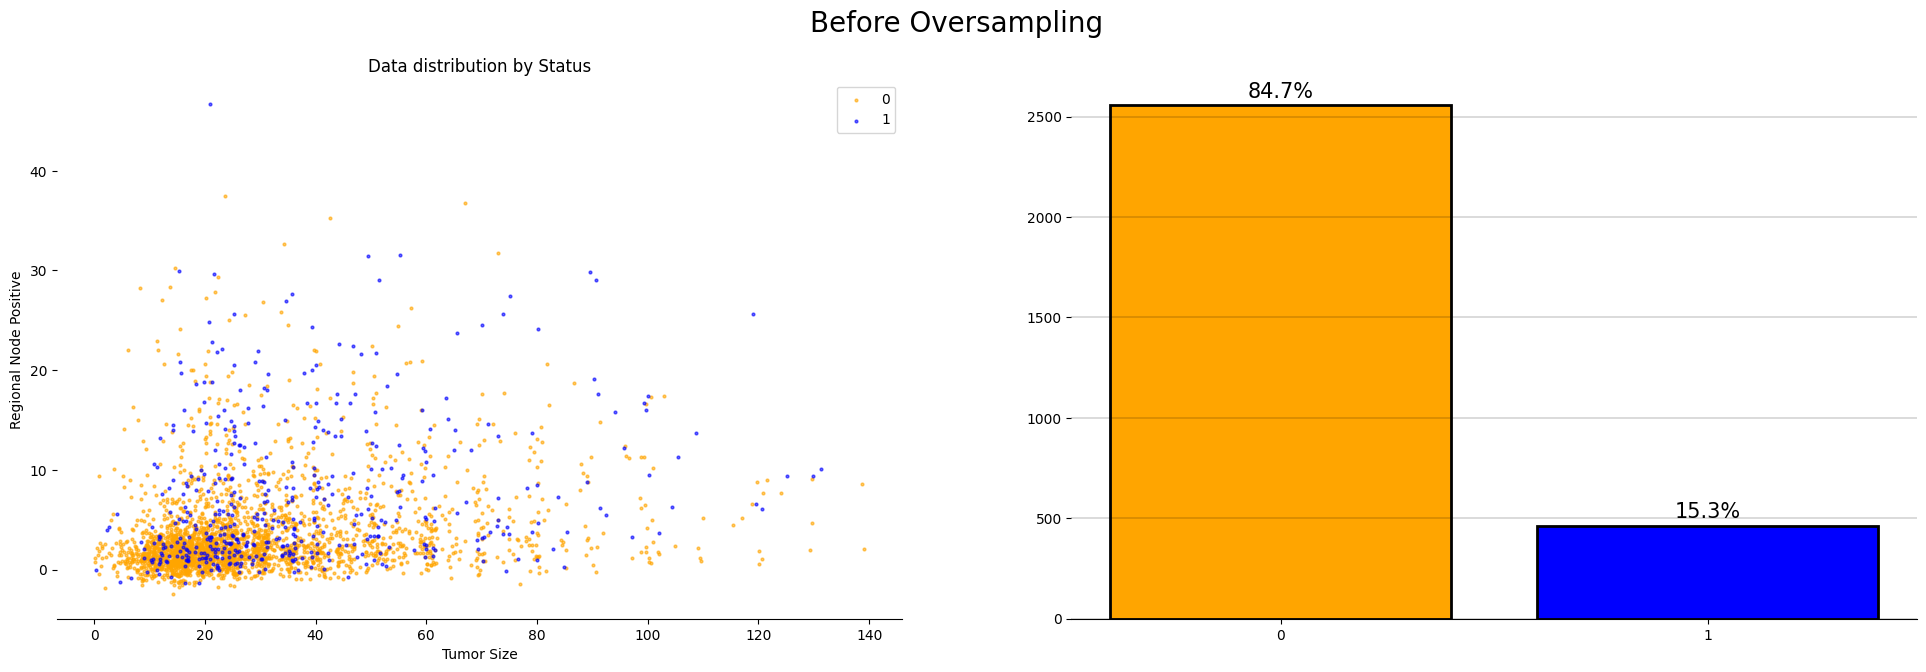

In [12]:
fig, ax       = plt.subplots(1, 2, figsize = (24, 7))
training_data = pd.merge(train_x, train_y, right_index = True, left_index = True)

plot_scatter(        training_data,          'Tumor Size',   'Regional Node Positive', ax[0], 
             hue_column = 'Status', xlabel = 'Tumor Size', ylabel = 'Regional Node Positive',
                 title  = 'Data distribution by Status')

plot_count(training_data['Status'], ax[1])
fig.suptitle('Before Oversampling', fontsize = 20)
plt.show()

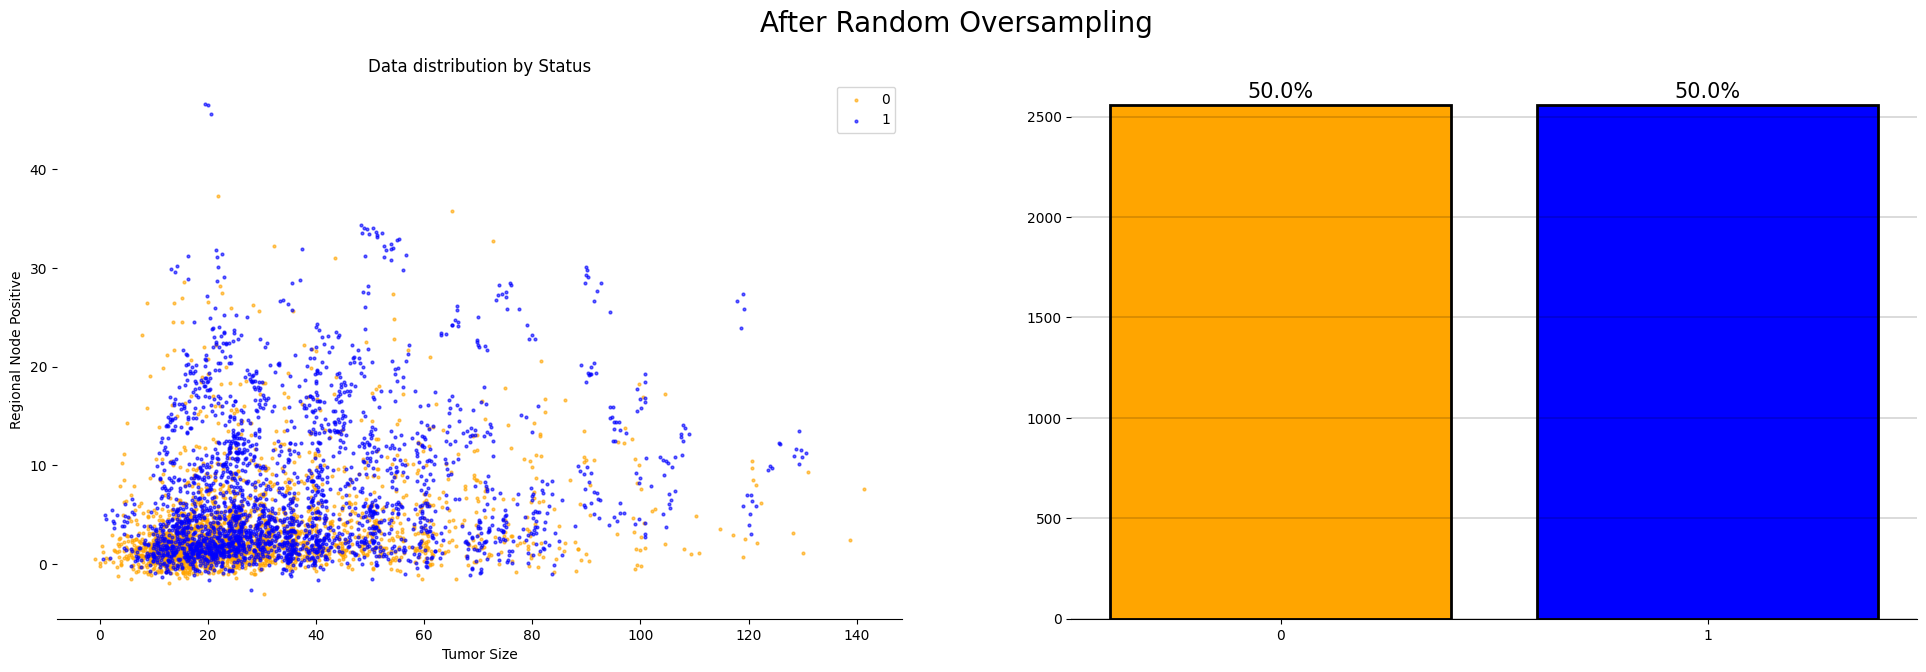

In [13]:
sampler                    = RandomOverSampler(random_state = seed)
train_x_over, train_y_over = sampler.fit_resample(train_x, train_y)

fig, ax       = plt.subplots(1, 2, figsize = (24, 7))
training_over = pd.merge(train_x_over, train_y_over, right_index = True, left_index = True)

plot_scatter(         training_over,             'Tumor Size',    'Regional Node Positive', ax[0], 
              hue_column = 'Status',    xlabel = 'Tumor Size',  ylabel = 'Regional Node Positive',
                   title = 'Data distribution by Status')

plot_count(training_over['Status'], ax[1])
fig.suptitle('After Random Oversampling', fontsize = 20)
plt.show()

Training - RandomOverSampler scores
==========  ===========  ========  ==========  ===========
  Accuracy    Precision    Recall    F1 Score    Auc Score
==========  ===========  ========  ==========  ===========
      0.87         0.89      0.84        0.86         0.94
==========  ===========  ========  ==========  ===========
Validation scores
==========  ===========  ========  ==========  ===========
  Accuracy    Precision    Recall    F1 Score    Auc Score
==========  ===========  ========  ==========  ===========
      0.84         0.48      0.66        0.55         0.84
==========  ===========  ========  ==========  ===========


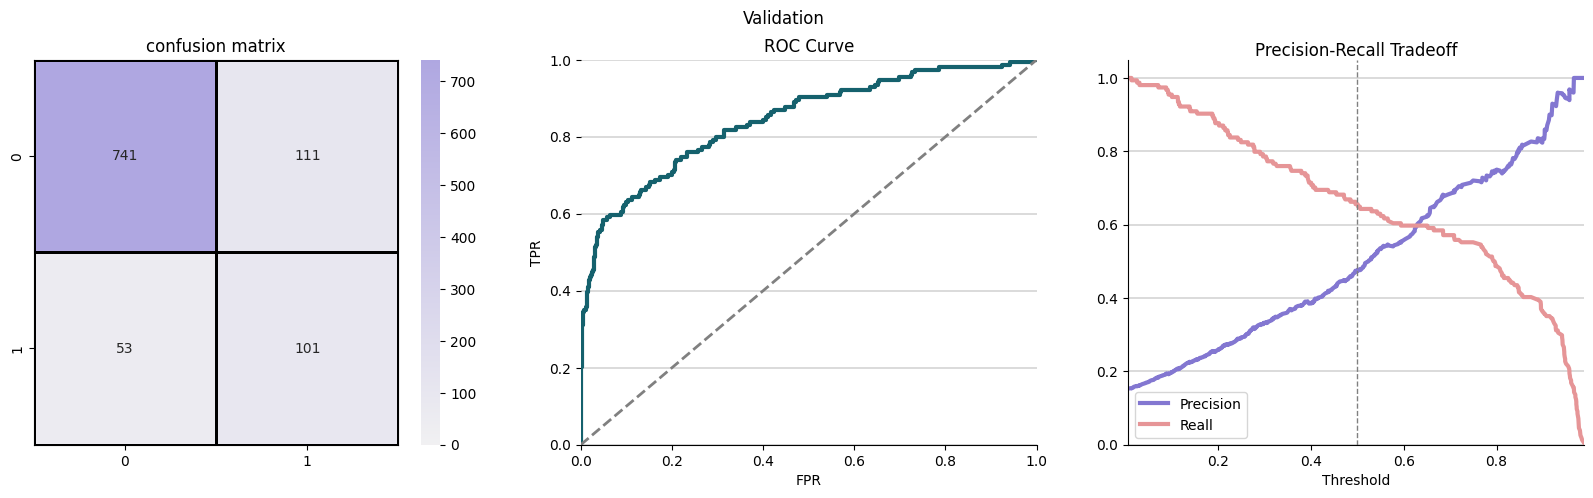

In [14]:
fit_pred_evaluate(model, train_x_over, train_y_over, test_x, test_y, 
                  train_label = 'Training - RandomOverSampler', graph_valutation_test = True)

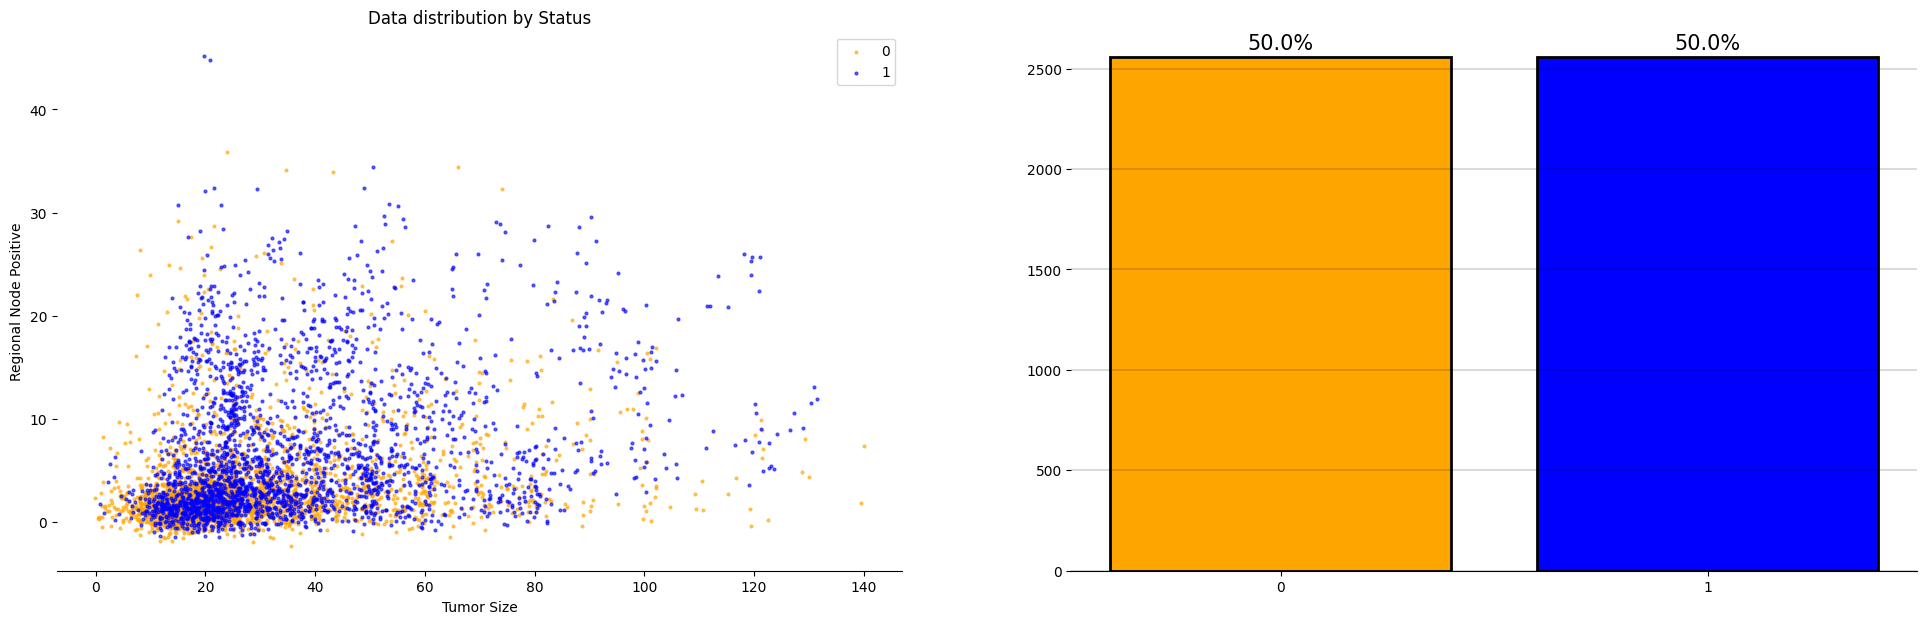

In [15]:
sampler                    = SMOTE(random_state = seed)
train_x_over, train_y_over = sampler.fit_resample(train_x, train_y)

fig, ax       = plt.subplots(1, 2, figsize = (24, 7))
training_over = pd.merge(train_x_over, train_y_over, right_index = True, left_index = True)

plot_scatter(training_over        ,          'Tumor Size',    'Regional Node Positive', ax[0],
             hue_column = 'Status', xlabel = 'Tumor Size',  ylabel = 'Regional Node Positive',
             title      = 'Data distribution by Status')

plot_count(training_over['Status'], ax[1])
plt.show()

Training - SMOTE Oversampling scores
==========  ===========  ========  ==========  ===========
  Accuracy    Precision    Recall    F1 Score    Auc Score
==========  ===========  ========  ==========  ===========
      0.93         0.96       0.9        0.93         0.98
==========  ===========  ========  ==========  ===========
Validation scores
==========  ===========  ========  ==========  ===========
  Accuracy    Precision    Recall    F1 Score    Auc Score
==========  ===========  ========  ==========  ===========
       0.9         0.72      0.54        0.61         0.86
==========  ===========  ========  ==========  ===========


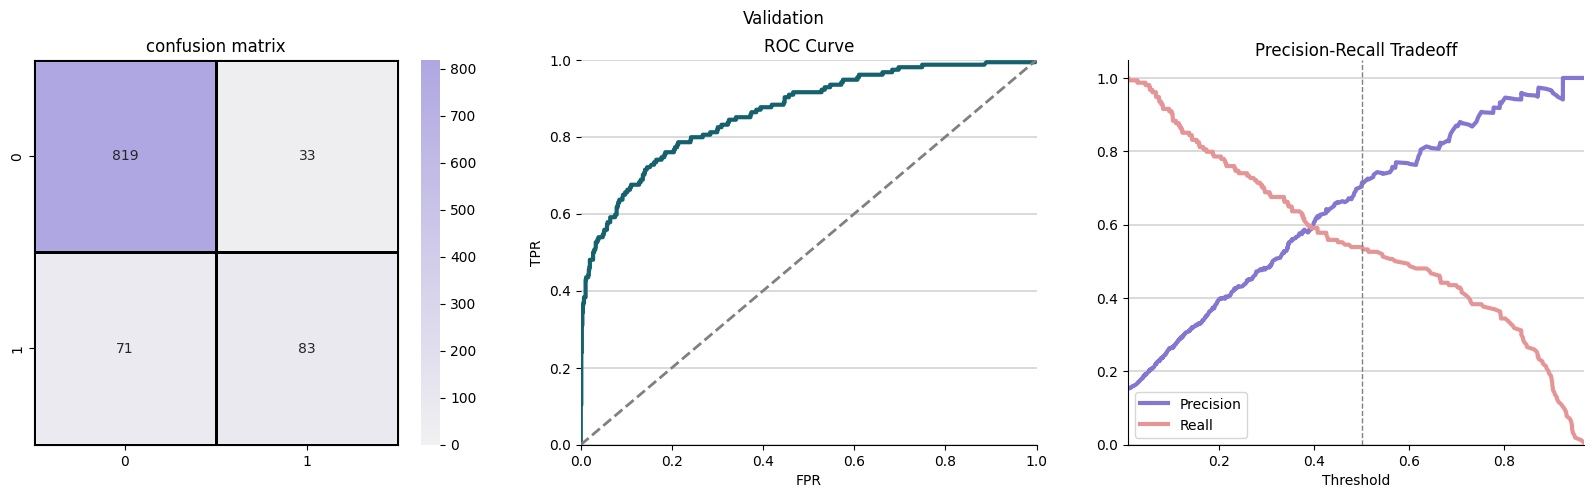

In [16]:
fit_pred_evaluate(model, train_x_over, train_y_over, test_x, test_y,
                  train_label = 'Training - SMOTE Oversampling', graph_valutation_test = True)

/opt/conda/envs/dove/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


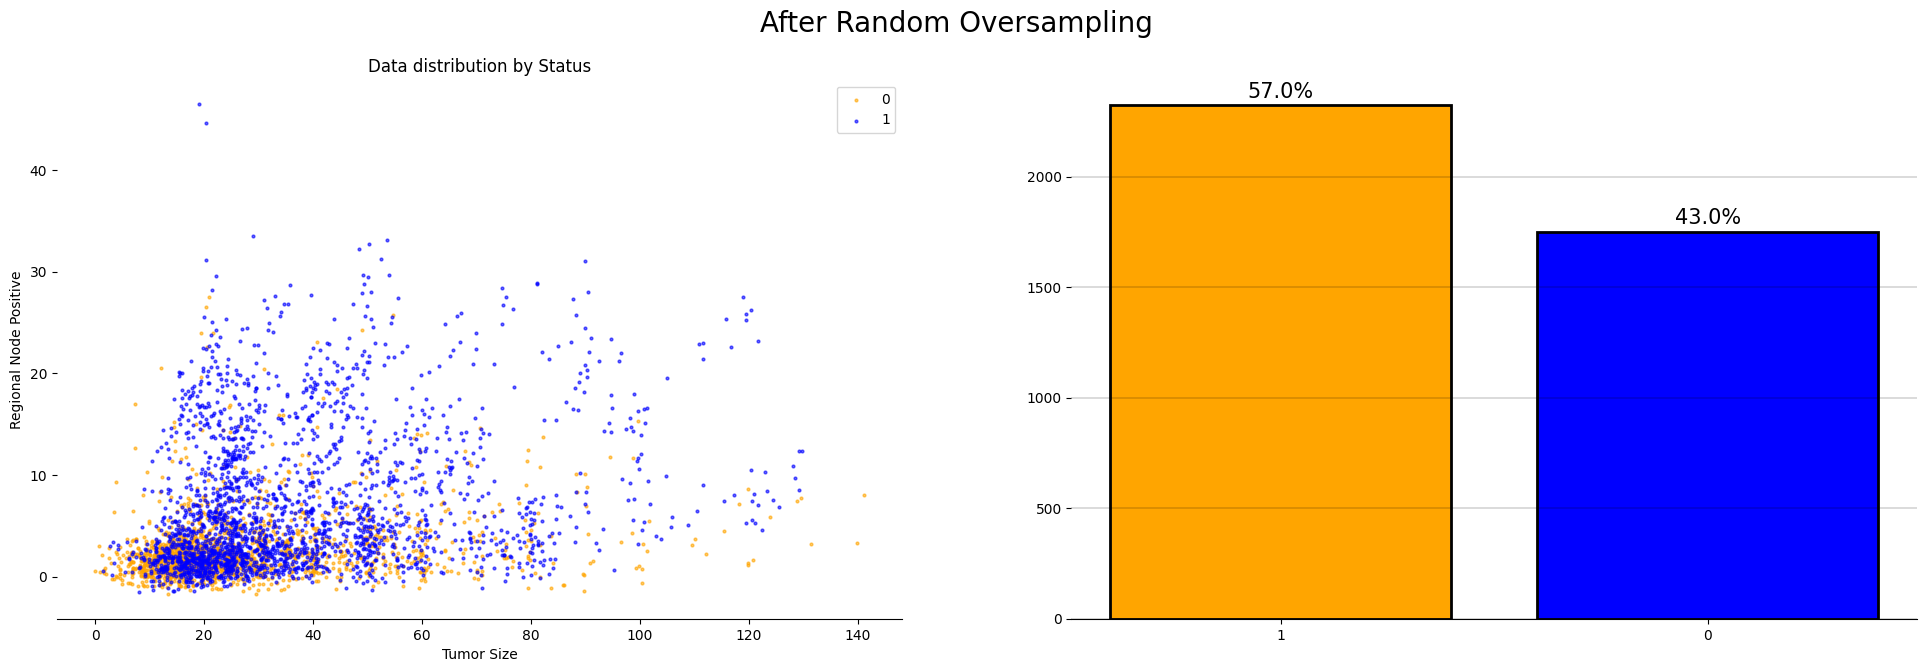

In [17]:
sampler                    = SMOTEENN(random_state = seed, n_jobs = -1)
train_x_over, train_y_over = sampler.fit_resample(train_x, train_y)

fig, ax       = plt.subplots(1, 2, figsize = (24, 7))
training_over = pd.merge(train_x_over, train_y_over, right_index = True, left_index = True)

plot_scatter(         training_over,             'Tumor Size',    'Regional Node Positive', ax[0], 
              hue_column = 'Status',    xlabel = 'Tumor Size',  ylabel = 'Regional Node Positive',
                   title = 'Data distribution by Status')

plot_count(training_over['Status'], ax[1])
fig.suptitle('After Random Oversampling', fontsize = 20)
plt.show()

Training - SMOTEENN scores
==========  ===========  ========  ==========  ===========
  Accuracy    Precision    Recall    F1 Score    Auc Score
==========  ===========  ========  ==========  ===========
      0.96         0.98      0.95        0.97         0.99
==========  ===========  ========  ==========  ===========
Validation scores
==========  ===========  ========  ==========  ===========
  Accuracy    Precision    Recall    F1 Score    Auc Score
==========  ===========  ========  ==========  ===========
      0.85          0.5      0.68        0.57         0.86
==========  ===========  ========  ==========  ===========


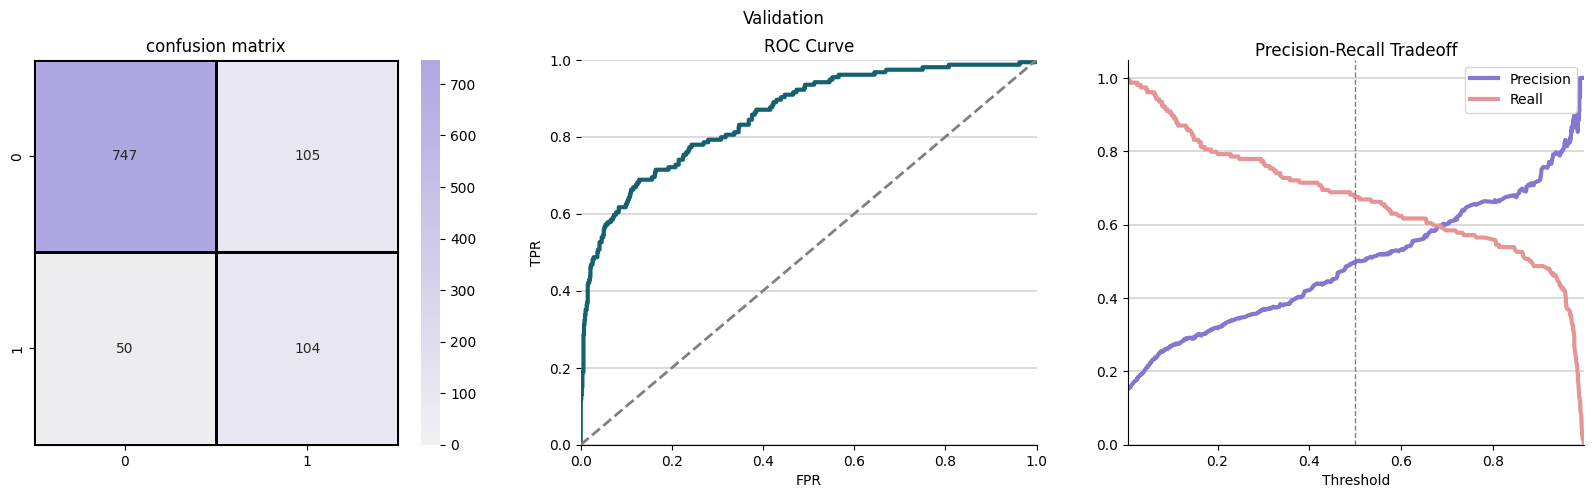

In [18]:
fit_pred_evaluate(model, train_x_over, train_y_over, test_x, test_y, 
                  train_label = 'Training - SMOTEENN', graph_valutation_test = True)

### ~ 코드 출처 ~
---
- Kaggle - Techniques for highly unbalanced data | [[캐글]](https://www.kaggle.com/code/antoniosabatini/techniques-for-highly-unbalanced-data)